In [29]:
import json,os
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
import plotter_lib as pl
import matplotlib.pyplot as plt


ligas = ["England","France","Germany", "Italy", "Spain"]
metricas = ['direct_play',
            'counterattack',
            'T_maintenance',
            'T_build_up',
            'T_zona_media',
            'flow_rate',
            'crossing',
            'pressure_point',
            'pressure_loss',
            'shots'
 ]

labels=["EN","FR","GE","IT","SP"]
ligaColor = {"England":"#9e0142", "France":"#f46d43", "Germany":"#66c2a5", "Spain":"#5e4fa2", "Italy":"#3288bd"}

colsnames = {"direct_play":"Direct play", 
        "counterattack": "Counterattack",
        "T_maintenance": "Maintenance",
        "T_build_up": "Build up",
        "T_zona_media": "Midfield play",
        "flow_rate":"Flow rate",
        "crossing":"Crossing",
        "pressure_point":"Pressure point",
        "pressure_loss":"Pressure loss",
        "shots":"Shots",
        "S1":"PC1",
        "S2":"PC2",
        "S3":"PC3",
        "S4":"PC4",
        "T_maintenance":"Maintenance"
}

directorio base del experimento:

In [8]:
db = '/home/chacoma/Lineas/Futbol/Ranking/ranking-futbol/juan/experiments/2025-10-23/txt'

Calculo del tau de kendall, calculado entre el ranking real y el dado por las metricas

In [ ]:

# el ranking final es del 1 al 20


K = {}

for liga in ligas:

    if liga!="Germany":
        r_true = np.linspace(1,20,20, dtype=int)
    else:
        r_true = np.linspace(1,18,18, dtype=int)

    K[liga]={}


    for metrica in metricas:

        pl.printr( f"{liga}, {metrica}" )

        K[liga][metrica] = { "tau":0, "pval":0 }


        arx= f"{db}/{liga}-{metrica}-g.txt"

        r_met = np.loadtxt(arx, usecols=[2], skiprows=1, dtype=int)

        tau, pval = kendalltau(r_met, r_true)

        K[liga][metrica]["tau"]=tau
        K[liga][metrica]["pval"]=pval

    print("\t")


England, shotsure_losst	
France, shotsure_losst	
Germany, shotsure_losst	
Italy, shotsure_losst	
Spain, shotsure_losst	


In [27]:
Tau = {}

for liga in ligas:

    Tau[liga]=[]

    for metrica in metricas:

        Tau[liga].append( K[liga][metrica]["tau"] )

In [49]:
ls = np.array(labels)

print (ls)

print (ls[index_sort])

['EN' 'FR' 'GE' 'IT' 'SP']
['IT' 'EN' 'GE' 'SP' 'FR']


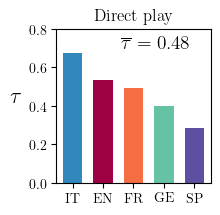

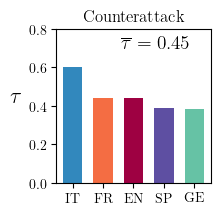

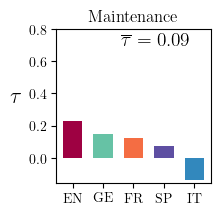

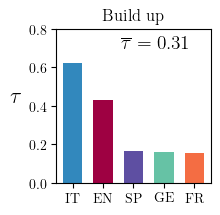

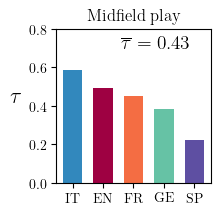

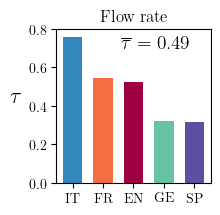

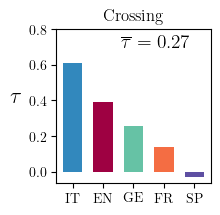

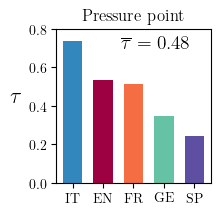

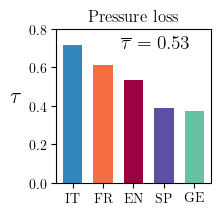

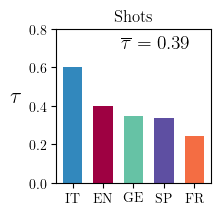

In [57]:
ls = np.array(labels)
x = np.linspace(0,5,5)

out = 'plots'
os.makedirs(out, exist_ok=True)

for metrica in metricas:

    # tomo metrica por liga con su color y ordeno
    Y = np.array([ [ K[liga][metrica]["tau"], K[liga][metrica]["pval"], liga, ligaColor[liga] ] for liga in ligas])
    
    index_sort = Y[:,0].argsort()[::-1]
    Y = Y[index_sort]

    y = Y[:,0].astype(float)
    y2= Y[:,1].astype(float)
    colors = Y[:,-1] 

    

    fig, ax1 = plt.subplots(   
        figsize=(2,2)
    )

    ax1.bar(x,y, color=colors)

    ax1.set_title(colsnames[metrica])
    ax1.set_ylabel(r"$\tau$", rotation=0, fontsize=16,labelpad=10)

    ax1.set_xticks(x)
    ax1.set_xticklabels(  ls[index_sort] )
    ax1.set_ylim(None, 0.8)

    tau_mean = np.mean(y)
    ax1.text(2,0.7, r'$\overline{\tau} = %.2f$'%tau_mean, fontsize=14)

    plt.savefig(
                f'{out}/{metrica}.svg',
                format='svg',          
                transparent=True    
            )
    

    plt.show()

    



Busco y ordeno temporalmente todos los partidos de las 5 ligas

El resultado sale como D[liga]= [ [dia partido, eq1, eq2, winner] ...  ], si fue empate winner=0

In [3]:
D={}

for liga in ligas:

    print (liga)

    arx = f'/home/chacoma/Lineas/Futbol/raw_data/pappalardo/matches/matches_{liga}.json'

    matches = json.load(open(arx,'r'))

    D[liga]=[]

    for i in range(len(matches)):


        match = matches[i]
        winner = str(matches[i]['winner'])

        fecha_str = match["dateutc"]
        naive_dt=datetime.strptime(fecha_str, formato)
        aware_dt_utc = naive_dt.replace(tzinfo=pytz.utc)
        timestamp = int(aware_dt_utc.timestamp())

        t1,t2 = list(match["teamsData"].keys())

        #print (t1, t2, winner)

        if winner!='0':
            D[liga].append( [timestamp, l2t2r[liga][t1], l2t2r[liga][t2], l2t2r[liga][winner]] )
        else:
            D[liga].append( [timestamp, l2t2r[liga][t1], l2t2r[liga][t2], 0] )

    D[liga]= sorted(D[liga], key= lambda a:a[0])


England
France
Germany
Italy
Spain


Calculo de la evolucion de rankigs de acuerdo al avance de las fechas

El resultado es Rankings[liga]= [ [posiciones fecha 1] .... [posiciones ultima fecha] ]

In [5]:
Rankings={}


for liga in ligas:

    nstep = 10 if liga!='Germany' else 9

    N = len(D[liga])

    eq2ptos={ n+1:0 for n in range(nstep*2) }

    Rankings[liga]=[]

    for n in range(0,N,nstep):

        # tomo partidos de la fecha
        d = D[liga][n:n+nstep]
        
        for t, e1, e2, w in d:

            # tomo puntos anteriores
            p1ant = eq2ptos[e1]
            p2ant = eq2ptos[e2]

            # actualizo respecto a resultado
            if w==0:
                p1act= p1ant+1
                p2act= p2ant+1
                
            else:
                if w==e1:
                    p1act = p1ant+3
                    p2act = p2ant
                else:
                    p1act = p1ant
                    p2act = p2ant+3

            # actualizo ptos totales
            eq2ptos[e1]=p1act
            eq2ptos[e2]=p2act

        ranki = [ t for t,p in sorted( eq2ptos.items(), key= lambda a:a[1], reverse=True )]

        Rankings[liga].append(ranki)
        


Calculo del tau de kendall

In [8]:
Tau={}


for liga in ligas:


    rfinal = Rankings[liga][-1]

    print (liga)

    T = len(Rankings[liga])

    X=[]

    for t in range(0,T):

        r1 = Rankings[liga][t]

        tau, p_value = kendalltau(r1, rfinal)

        X.append( [t+1, tau, p_value] )


    Tau[liga]=pd.DataFrame(X, columns=['t', "tau", "pval"])




England
France
Germany
Italy
Spain


grafico del tau de kendall

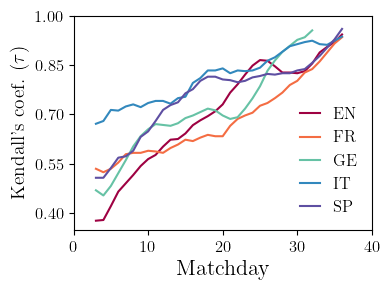

In [14]:

plot = pl.Plotter()

win= 5

for l,liga in enumerate(ligas):

    df = Tau[liga]

    tau_rolling = df['tau'].rolling(window=win, center=True)

    t = df['t']
    mu = tau_rolling.mean()
    sd = tau_rolling.std()/np.sqrt(win)
                 
    #plot.ax.fill_between(t, mu-sd, mu+sd, alpha=0.2,  color=ligaColor[liga] )

    plot.ax.plot( t,mu, label=labels[l], c=ligaColor[liga] )


plot.ax.set_xticks( np.linspace(0,40,5) )
plot.ax.set_yticks( np.linspace(0.4,1,5) )
plot.ax.set_xlabel("Matchday", fontsize=16)
plot.ax.set_ylabel("Kendall's coef.\t"+r"$(\tau)$", fontsize=14)
plot.show("kendall.png",loc=4)



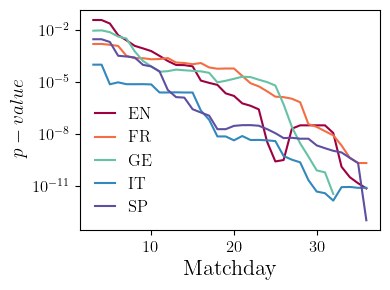

In [15]:
plot = pl.Plotter()

win= 5

for l,liga in enumerate(ligas):

    df = Tau[liga]

    tau_rolling = df['pval'].rolling(window=win, center=True)

    t = df['t']
    mu = tau_rolling.mean()
    sd = tau_rolling.std()/np.sqrt(win)
                 
    #plot.ax.fill_between(t, mu-sd, mu+sd, alpha=0.2,  color=ligaColor[liga] )

    plot.ax.plot( t,mu, label=labels[l], c=ligaColor[liga] )

plot.ax.set_xlabel("Matchday", fontsize=16)
plot.ax.set_ylabel("$p-value$", fontsize=14)
plot.ax.set_yscale('log')
plot.show('pvalue.png',loc=3)





In [17]:
db = "kendallxliga"
os.makedirs(db, exist_ok=True)


for liga in ligas:

    arx = f"{db}/kendall_{liga}.csv"

    Tau[liga].to_csv( arx, index=False )

